### 1.Set up and load Data

1.1 Install Dependencies and Setup

In [ ]:
%pip install tensorflow tenserflow-gpu opencv-python matplotlib

In [ ]:
%pip list

In [3]:
import tensorflow as tf
import os

In [4]:
print("TF version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("GPU Device:", tf.test.gpu_device_name())


TF version: 2.10.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Device: /device:GPU:0


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# Avoid OOM error by setting GPU memory consumption growth
tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

1.2 Remove dodgy images

In [8]:
import cv2
import imghdr

In [53]:
data_dir = 'data'

In [54]:
os.listdir(data_dir)

['happy people', 'sad people']

In [55]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [56]:
for image_class in os.listdir(data_dir): # list image class
    for image in os.listdir(os.path.join(data_dir, image_class)): # list image in each class
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image is not  in ext list  {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_exts))

Image is not  in ext list  data\happy people\hand-drawing-cartoon-character-happy-260nw-156289214.jpg
Image is not  in ext list  data\happy people\Happy People.jpg
Image is not  in ext list  data\happy people\istock-508455188-033183f45ba393ed4745b2dd1213c390.jpg
Image is not  in ext list  data\happy people\smiling-woman_W6GFOSFAXA.jpg
Image is not  in ext list  data\sad people\close-sad-pensive-millennial-woman-260nw-2458168367.jpg
Image is not  in ext list  data\sad people\d-depressed-sad-person-rendering-frustrated-upset-man-sittin.jpg
Image is not  in ext list  data\sad people\depositphotos_19568511-stock-photo-teenage-girl-looking-thou.jpg
Image is not  in ext list  data\sad people\portrait-sad-man-600nw-126009806.jpg
Image is not  in ext list  data\sad people\sad-people-are-standing-rooftop-092116870_prevstill.jpeg
Image is not  in ext list  data\sad people\sad-people-stand-sit-illustration-600w-1189541662.jpg
Image is not  in ext list  data\sad people\sad-person-pictures-1220-x-7

1.3 Load Data

In [57]:
import numpy as np
from matplotlib import pyplot as plt

In [58]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 159 files belonging to 2 classes.


In [59]:
data_interator = data.as_numpy_iterator()

In [66]:
# Get another batch from the interator
batch = data_interator.next()

In [61]:
# Imaages representd as  numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [62]:
# Class 1 = sad 
# Class 0 = happy
batch[1]

array([0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0])

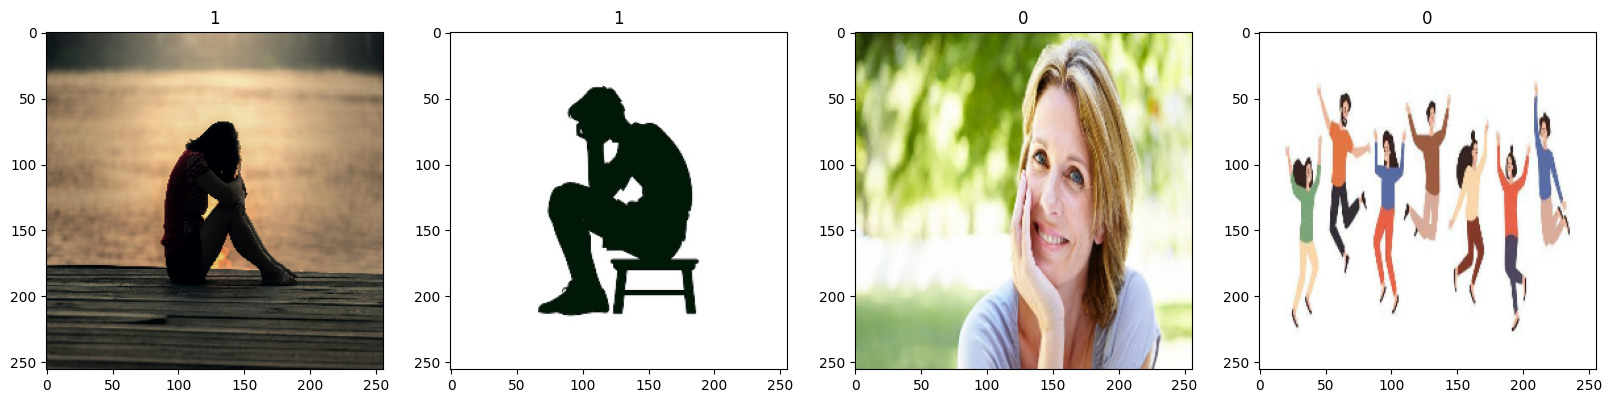

In [67]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

1.4 Scale Data

In [36]:
scaled = batch[0] /255

In [38]:
scaled.max()

1.0

### 2.Preprocess data

1.1 Scale Data

In [68]:
data = data.map(lambda x,y: (x/255,y))

In [ ]:
scaled_iterator = data.as_numpy_iterator()

In [70]:
scaled_iterator.next()

(array([[[[8.96507382e-01, 9.63174045e-01, 7.90624976e-01],
          [9.02293980e-01, 9.68960643e-01, 7.96411633e-01],
          [8.99816155e-01, 9.74325955e-01, 7.97855377e-01],
          ...,
          [5.52271008e-01, 8.73839617e-01, 6.85604334e-01],
          [5.49352765e-01, 8.74843001e-01, 6.94450855e-01],
          [5.46763957e-01, 8.72254133e-01, 6.91861987e-01]],
 
         [[9.16149676e-01, 9.78894770e-01, 7.97713697e-01],
          [9.12316203e-01, 9.75061297e-01, 7.97648609e-01],
          [9.08712447e-01, 9.72866893e-01, 7.92941928e-01],
          ...,
          [5.51715672e-01, 8.73284340e-01, 6.85048997e-01],
          [5.52941203e-01, 8.74509811e-01, 6.86274529e-01],
          [5.45098066e-01, 8.74509811e-01, 6.82352960e-01]],
 
         [[9.33088243e-01, 9.87925112e-01, 7.95963526e-01],
          [9.28370118e-01, 9.82425690e-01, 7.92807877e-01],
          [9.27470148e-01, 9.82046545e-01, 7.90866256e-01],
          ...,
          [5.52941203e-01, 8.74509811e-01, 6.8504